# Database construction

In this notebook I made an exploratory analysis in which I took several variables from different sources and with them I made an analysis of the correlation of the variables and how the countries behaved. I also test clustering between different countries to see what the relationship was between them and thus generate a model that would allow me to improve performance using Lstm.

Information about the cases: 

https://www.kaggle.com/roche-data-science-coalition/uncover?


Information related the economic of each country

https://data.worldbank.org/

In the Kmeans session you can see in the clustering algorithm made from three clusters in the CreatTheFinalDB session the database is created that will be used in the Book myaproachrnn in which different models of recurrent neural networks are tested.



In [0]:
pip install geopandas

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 14.7MB 298kB/s 
     |████████████████████████████████| 10.9MB 23.3MB/s 


In [0]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_log_error

from datetime import datetime
from datetime import timedelta

from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the db

In [5]:
!wget -nc https://www.dropbox.com/s/s43ocxw83h95pdg/interezants.zip?dl=0


--2020-06-09 03:03:23--  https://www.dropbox.com/s/s43ocxw83h95pdg/interezants.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s43ocxw83h95pdg/interezants.zip [following]
--2020-06-09 03:03:23--  https://www.dropbox.com/s/raw/s43ocxw83h95pdg/interezants.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0db3ee261a5479757c998c6a96.dl.dropboxusercontent.com/cd/0/inline/A5SSTMNoMeiOUxRCDzVhmIL-KIrB8nQogrZOXeje71UB_pwKZBNE6JRdYXdNpZn8BzqY70dvMm1QrR6XDg02AlOm9-uneVx3UUdvDvBwbUAznH3Xwk7wPImWa5-wPQdncIg/file# [following]
--2020-06-09 03:03:24--  https://uc0db3ee261a5479757c998c6a96.dl.dropboxusercontent.com/cd/0/inline/A5SSTMNoMeiOUxRCDzVhmIL-KIrB8nQogrZOXeje71UB_pwKZBNE6JRdYXdNpZn8BzqY70dvMm1QrR6XDg02AlOm9-uneVx3UUdv

In [6]:
!unzip interezants.zip?dl=0

Archive:  interezants.zip?dl=0
  inflating: interezants/.DS_Store   
  inflating: interezants/dfallvariables.csv  
  inflating: interezants/datak.csv   
  inflating: interezants/worldbank.csv  
  inflating: interezants/coronavirus-disease-covid-19-statistics-and-research (1).csv  
  inflating: interezants/total-covid-19-tests-performed-by-country.csv  
  inflating: interezants/covid19-global-forecasting-week-5/MyaproachRNN.ipynb  
  inflating: interezants/covid19-global-forecasting-week-5/Italy  
  inflating: interezants/covid19-global-forecasting-week-5/best_model.h5  
  inflating: interezants/covid19-global-forecasting-week-5/Portugal  
  inflating: interezants/covid19-global-forecasting-week-5/Ireland  
  inflating: interezants/covid19-global-forecasting-week-5/Israel  
  inflating: interezants/covid19-global-forecasting-week-5/Denmark  
  inflating: interezants/covid19-global-forecasting-week-5/Japan  
  inflating: interezants/covid19-global-forecasting-week-5/India  
  inflating: 

In [7]:
%cd interezants
%ls

/content/interezants
'coronavirus-disease-covid-19-statistics-and-research (1).csv'
 covid19-global-forecasting-week-5/
 datak.csv
 dfallvariables.csv
 regional-mobility.csv
 total-covid-19-tests-performed-by-country.csv
 worldbank.csv


In [0]:
import numpy as np # linear algebra
import pandas as pd

In [0]:
covid_statistics_research=pd.read_csv('coronavirus-disease-covid-19-statistics-and-research (1).csv')
regionalmobility=pd.read_csv('regional-mobility.csv')
testsperformed=pd.read_csv('total-covid-19-tests-performed-by-country.csv')
worldbank=pd.read_csv('worldbank.csv')


In [0]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [0]:
!wget -nc https://www.dropbox.com/s/s43ocxw83h95pdg/interezants.zip?dl=0


--2020-06-09 02:25:43--  https://www.dropbox.com/s/s43ocxw83h95pdg/interezants.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/s43ocxw83h95pdg/interezants.zip [following]
--2020-06-09 02:25:44--  https://www.dropbox.com/s/raw/s43ocxw83h95pdg/interezants.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5c945a56676a40e97677091841.dl.dropboxusercontent.com/cd/0/inline/A5RhwF8iiIX9TGGsb1pM0hN9o7lb1-gncpFt9wevmFTEqfpxfNeHVV3dNRtb-F6o79jOzLTHGAnOwT3mEeuQtHgfR9DpydNMCVDUeJdNYKavG01ZwKg6Gvtutq1_PrDREZc/file# [following]
--2020-06-09 02:25:44--  https://uc5c945a56676a40e97677091841.dl.dropboxusercontent.com/cd/0/inline/A5RhwF8iiIX9TGGsb1pM0hN9o7lb1-gncpFt9wevmFTEqfpxfNeHVV3dNRtb-F6o79jOzLTHGAnOwT3mEeuQtHgfR9DpydNMCVDU

In [0]:
!unzip interezants.zip?dl=0

Archive:  interezants.zip?dl=0
  inflating: interezants/.DS_Store   
  inflating: interezants/dfallvariables.csv  
  inflating: interezants/datak.csv   
  inflating: interezants/worldbank.csv  
  inflating: interezants/coronavirus-disease-covid-19-statistics-and-research (1).csv  
  inflating: interezants/total-covid-19-tests-performed-by-country.csv  
  inflating: interezants/covid19-global-forecasting-week-5/MyaproachRNN.ipynb  
  inflating: interezants/covid19-global-forecasting-week-5/Italy  
  inflating: interezants/covid19-global-forecasting-week-5/best_model.h5  
  inflating: interezants/covid19-global-forecasting-week-5/Portugal  
  inflating: interezants/covid19-global-forecasting-week-5/Ireland  
  inflating: interezants/covid19-global-forecasting-week-5/Israel  
  inflating: interezants/covid19-global-forecasting-week-5/Denmark  
  inflating: interezants/covid19-global-forecasting-week-5/Japan  
  inflating: interezants/covid19-global-forecasting-week-5/India  
  inflating: 

## coronavirus-disease-covid-19-statistics-and-research (1).csv

These deb show several atributes, of each country, we are going to make statistics about that 

In [0]:
#covid_statistics_research=covid_statistics_research.dropna()
covid_statistics_research

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed_per_thousand,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
1,ABW,Aruba,2020-03-20,4,2,0,0,37.465,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.56,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
2,ABW,Aruba,2020-03-24,12,8,0,0,112.395,74.930,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.84,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
3,ABW,Aruba,2020-03-25,17,5,0,0,159.227,46.831,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.84,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
4,ABW,Aruba,2020-03-26,19,2,0,0,177.959,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.84,106766.0,584.8,41.2,13.085,7.452,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18856,NaN,International,2020-02-28,705,0,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18857,NaN,International,2020-02-29,705,0,6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18858,NaN,International,2020-03-01,705,0,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18859,NaN,International,2020-03-02,705,0,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we are going to create a new dataframe with statistics by each country

In [0]:
gini(covid_statistics_research[covid_statistics_research.location=='Aruba'].iloc[:,3:].values.astype('float64'))

nan

In [0]:
ndf=[]
ginii=[]
for i in list(set(covid_statistics_research.location.unique()) & set(regionalmobility.country.unique())):
    ndf.append(covid_statistics_research[covid_statistics_research.location==i].describe().iloc[1])
    ginii.append(gini(covid_statistics_research[covid_statistics_research.location==i].iloc[:,3].values.astype('float64')))
nstatisticsdf=pd.DataFrame(ndf)

In [0]:
nstatisticsdf['Countries']=list(set(covid_statistics_research.location.unique()) & set(regionalmobility.country.unique()))
nstatisticsdf['gini']=ginii

In [0]:
nstatisticsdf

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,Countries,gini
mean,1792.964286,125.485714,11.735714,0.885714,419.842600,29.383893,2.748007,0.207357,NaN,NaN,NaN,NaN,NaN,NaN,48.344338,4270563.0,232.128,33.7,2.345,1.114,65530.537,NaN,132.235,15.84,2.7,37.0,NaN,2.00,Kuwait,0.814478
mean,6807.601399,395.762238,660.167832,42.587413,55.928496,3.251444,5.423667,0.349867,2.882910e+04,1124.604317,0.223590,0.008619,1139.984848,0.008705,33.800362,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,Mexico,0.809616
mean,4963.886076,338.455696,91.215190,4.886076,35.016647,2.387559,0.643353,0.034471,4.059416e+04,2615.243243,0.246579,0.015865,2403.371429,0.014557,75.572297,164689383.0,1265.036,27.5,5.098,3.262,3523.984,14.8,298.003,8.38,1.0,44.7,34.808,0.80,Bangladesh,0.710500
mean,177.345070,3.105634,2.563380,0.049296,7.499043,0.131362,0.108426,0.002085,4.460345e+04,761.094595,1.872773,0.031959,801.352941,0.033632,24.187600,23816775.0,NaN,42.2,NaN,8.353,NaN,NaN,103.957,NaN,NaN,NaN,NaN,NaN,Taiwan,0.561411
mean,411.347518,8.177305,5.014184,0.148936,89.758388,1.784291,1.094075,0.032470,8.608461e+04,3358.211268,17.851639,0.696366,3469.676923,0.719492,44.436103,4822233.0,18.206,37.9,15.322,9.720,36085.843,NaN,128.797,8.08,14.8,17.2,NaN,2.61,New Zealand,0.631060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mean,1533.569620,46.088608,166.734177,5.987342,162.872260,4.894857,17.707961,0.635961,4.631525e+04,1949.191781,4.794342,0.201740,1877.943662,0.194437,66.798533,9660350.0,108.043,43.4,18.577,11.976,26777.561,0.5,278.296,7.55,26.8,34.8,NaN,7.02,Hungary,0.485437
mean,75250.401408,1637.711268,7807.549296,196.394366,1609.469599,35.027662,166.989303,4.200542,1.372301e+06,NaN,29.351000,NaN,33260.240000,0.711360,43.163835,46754783.0,93.105,45.5,19.436,13.799,34272.360,1.0,99.403,7.17,27.4,31.4,NaN,2.97,Spain,0.642931
mean,2204.885714,103.342857,15.271429,0.500000,120.880368,5.665676,0.837206,0.027426,1.685831e+05,8403.250000,8.978333,0.447588,8366.838710,0.445581,77.973667,18776707.0,6.681,30.6,6.991,4.625,24055.588,0.1,466.792,7.11,7.0,43.1,98.999,6.70,Kazakhstan,0.545784
mean,1137.563380,55.549296,2.957746,0.084507,668.532408,32.645655,1.738317,0.049683,1.031132e+05,4249.461538,60.598328,2.497327,3260.828571,1.916357,41.165263,1701583.0,1935.907,32.4,2.372,1.387,43290.705,NaN,151.689,16.52,5.8,37.6,NaN,2.00,Bahrain,0.751455


## regionalmobility

In [0]:
regionalmobility


,country,region,date,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential
0,United Arab Emirates,Total,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,United Arab Emirates,Total,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,United Arab Emirates,Total,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,United Arab Emirates,Total,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,United Arab Emirates,Total,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
78727,Zimbabwe,Total,2020-04-13,-71.0,-63.0,-51.0,-83.0,-80.0,49.0
78728,Zimbabwe,Total,2020-04-14,-63.0,-53.0,-47.0,-78.0,-64.0,41.0
78729,Zimbabwe,Total,2020-04-15,-62.0,-50.0,-51.0,-77.0,-65.0,42.0
78730,Zimbabwe,Total,2020-04-16,-62.0,-50.0,-48.0,-77.0,-64.0,42.0


In [0]:
ndf=[]
for i in list(set(covid_statistics_research.location.unique()) & set(regionalmobility.country.unique())):
    ndf.append(regionalmobility[regionalmobility.country==i].describe().iloc[1])
nsregionalmobility=pd.DataFrame(ndf)

In [0]:
nsregionalmobility['Countries']=list(set(covid_statistics_research.location.unique()) & set(regionalmobility.country.unique()))

In [0]:
nsregionalmobility

,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,Countries
mean,-33.718821,-16.979592,-28.795918,-23.562358,-25.029478,14.254042,Kuwait
mean,-22.172679,-6.691679,-18.118807,-21.675806,-15.598846,7.622896,Mexico
mean,-28.111111,-16.634921,-10.015873,-25.492063,-18.333333,10.238095,Bangladesh
mean,-10.206349,0.984127,-2.349206,-17.888889,3.650794,3.206349,Taiwan
mean,-35.639810,-14.363198,-38.321361,-31.490255,-17.955619,9.979104,New Zealand
...,...,...,...,...,...,...,...
mean,-20.332829,-7.965231,8.784710,-18.775510,-20.721088,8.175868,Hungary
mean,-49.685714,-27.008744,-38.167460,-44.393991,-36.395238,14.793691,Spain
mean,-20.587302,-10.380952,-8.190476,-12.079365,-19.269841,7.111111,Kazakhstan
mean,-25.857143,-9.063492,-27.111111,-22.349206,-10.619048,9.111111,Bahrain


## total-covid-19-tests-performed-by-country


In [0]:
testsperformed

,entity,code,year,total_covid_19_tests
0,Armenia,ARM,57,813
1,Australia,AUS,59,113615
2,Australia - Australian Capital Territory,NaN,59,2062
3,Australia - New South Wales,NaN,58,39089
4,Australia - Queensland,NaN,58,27000
...,...,...,...,...
72,United Arab Emirates,ARE,55,125000
73,United Kingdom,GBR,58,64621
74,United States,USA,58,103945
75,United States - CDC samples tested,NaN,53,37646


## worldbank


In [0]:
worldbank


,Classification Name,Classification Code,Time,Time Code,Country Name,Country Code,,1000000:GROSS DOMESTIC PRODUCT [1000000],9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],1101110:Bread and cereals [1101110],1101120:Meat [1101120],1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]
0,NaN,NaN,NaN,NaN,NaN,NaN,Scale (Precision),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000),Unit (0.000)
1,PPPs (US$ = 1),PPPGlob,2017.0,YR2017,East Asia & Pacific (ICP),EAB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PPPs (US$ = 1),PPPGlob,2017.0,YR2017,Australia,AUS,NaN,1.466,1.529,1.469,1.606,1.618,1.763,1.461,1.445,1.716,1.533,1.402,1.624,1.704,1.828,1.522,2.579,2.196,3.139,1.266,1.970,1.459,1.188,1.568,1.200,1.986,0.896,1.438,0.983,1.651,1.447,1.305,1.457,1.260,1.044,1.446,1.535,1.534,1.580,1.313,1.554,1.572,1.305,1.305,1.480,NaN,NaN,NaN
3,PPPs (US$ = 1),PPPGlob,2017.0,YR2017,Brunei Darussalam,BRN,NaN,0.647,0.697,0.648,1.162,1.153,0.987,1.086,0.765,1.526,1.431,1.450,1.378,1.345,1.052,1.267,0.999,1.841,0.508,1.151,0.319,0.752,0.528,1.280,2.802,0.793,1.206,0.882,0.311,0.550,0.614,1.384,0.755,0.384,0.347,0.421,0.757,0.754,1.899,0.327,1.485,1.050,1.383,1.391,0.652,NaN,NaN,NaN
4,PPPs (US$ = 1),PPPGlob,2017.0,YR2017,Cambodia,KHM,NaN,1428.354,1488.798,1372.850,2598.604,2584.867,2235.297,2891.110,1933.535,3792.457,4344.869,2

In [0]:
type(worldbank['Country Name'])

pandas.core.series.Series

In [0]:
worldbank.iloc[1:,8:]=worldbank.iloc[1:,8:].astype(float)

In [0]:
worldbank=worldbank.iloc[1:]


In [0]:
ndf=[]
for i in list(set(covid_statistics_research.location.unique()) & set(regionalmobility.country.unique())):
    ndf.append(worldbank[worldbank['Country Name']==i].iloc[1:,8:].astype(float).describe().iloc[1])
nsworldbank=pd.DataFrame(ndf)

In [0]:
nsworldbank['Countries']=list(set(covid_statistics_research.location.unique()) & set(regionalmobility.country.unique()))

In [0]:
nsworldbank

,9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],1101110:Bread and cereals [1101110],1101120:Meat [1101120],1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS],Countries
mean,2370.725741,3019.117556,281.521333,263.000370,64.190519,110.583667,141.499444,63.485704,54.452370,74.128148,80.008815,40.499111,36.545778,58.454852,17.185148,0.442000,26.994259,177.153370,737.858407,256.801741,253.806926,179.780407,38.223778,96.348407,114.916259,159.620481,471.009667,66.973000,193.700185,1389.508000,2041.755370,1579.209370,773.778778,910.935889,1667.693519,1635.685000,15.030222,1162.526630,933.100556,99.866593,0.280000,3539.114963,5354.065148,0.2915,3574277.0,0.0515,Kuwait
mean,2313.722296,2666.482741,556.207556,494.239704,151.832926,201.430667,38.783407,99.909667,78.670148,75.065444,54.886519,60.475333,73.574407,121.199741,96.525704,81.477741,45.177222,86.215815,457.944926,152.791741,198.009593,417.333222,140.920815,199.842185,100.789037,132.616630,471.858889,126.403815,279.768296,-8.493074,1969.197704,628.989852,394.195111,279.337556,874.593111,781.189037,258.246148,581.918407,31.441889,171.911222,0.591571,-66.381778,3778.358185,15.6750,119437500.0,1.7140,Mexico
mean,1123.712556,1162.650556,552.138148,551.505185,278.387593,45.217778,126.960407,41.315185,40.371630,28.280222,85.154741,17.141852,87.561444,10.130741,30.334185,1.438560,22.741148,77.187111,221.653111,42.205259,53.408556,51.234000,21.592074,43.864889,10.561593,19.621926,88.388111,31.792704,49.611852,2.966080,1012.635222,103.228815,29.361074,77.379593,464.797963,459.844481,122.347741,407.504704,14.429407,13.284704,3.531048,-104.645000,1691.408333,77.2950,155750000.0,2.2340,Bangladesh
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Taiwan
mean,3252.490630,4014.298000,497.925333,444.565815,111.974000,135.556148,83.276444,105.580148,58.696778,101.779778,99.825222,97.955593,249.619963,148.750704,258.73

Now, how we had each characteristics per countrie, we are going to concatenate.

In [0]:
result = pd.concat([nsregionalmobility,nstatisticsdf, nsworldbank], axis=1).reindex()

In [0]:
df = result.loc[:,~result.columns.duplicated()]

In [0]:
cols = df.columns.tolist()
cols

['retail',
 'grocery_and_pharmacy',
 'parks',
 'transit_stations',
 'workplaces',
 'residential',
 'Countries',
 'total_cases',
 'new_cases',
 'total_deaths',
 'new_deaths',
 'total_cases_per_million',
 'new_cases_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'total_tests',
 'new_tests',
 'new_tests_smoothed',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed_per_thousand',
 'stringency_index',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'cvd_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'handwashing_facilities',
 'hospital_beds_per_100k',
 'gini',
 '9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000]',
 '9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000]',
 '1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000]',
 '1101100:FOOD [1101100]',
 '1101110:Bread and cereals [1101110]',
 '1101120:Meat [1101120]',
 '110

In [0]:
df = df[['Countries','retail',
 'grocery_and_pharmacy',
 'parks',
 'transit_stations',
 'workplaces',
 'residential',
 'total_cases',
 'new_cases',
 'total_deaths',
 'new_deaths',
 'total_cases_per_million',
 'new_cases_per_million',
 'total_deaths_per_million',
 'new_deaths_per_million',
 'total_tests',
 'new_tests',
 'new_tests_smoothed',
 'total_tests_per_thousand',
 'new_tests_per_thousand',
 'new_tests_smoothed_per_thousand',
 'stringency_index',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'aged_70_older',
 'gdp_per_capita',
 'extreme_poverty',
 'cvd_death_rate',
 'diabetes_prevalence',
 'female_smokers',
 'male_smokers',
 'handwashing_facilities',
 'hospital_beds_per_100k',
 'gini',
 '9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000]',
 '9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000]',
 '1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000]',
 '1101100:FOOD [1101100]',
 '1101110:Bread and cereals [1101110]',
 '1101120:Meat [1101120]',
 '1101130:Fish and seafood [1101130]',
 '1101140:Milk, cheese and eggs [1101140]',
 '1101150:Oils and fats [1101150]',
 '1101160:Fruit [1101160]',
 '1101170:Vegetables [1101170]',
 '1101180:Sugar, jam, honey, chocolate and confectionery [1101180]',
 '1101190:Food products n.e.c. (Class) [1101190]',
 '1101200:NON-ALCOHOLIC BEVERAGES [1101200]',
 '1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]',
 '1102100:ALCOHOLIC BEVERAGES [1102100]',
 '1102200:TOBACCO [1102200]',
 '1103000:CLOTHING AND FOOTWEAR [1103000]',
 '9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]',
 '1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]',
 '9080000:ACTUAL HEALTH [9080000]',
 '1107000:TRANSPORT [1107000]',
 '1107100:PURCHASE OF VEHICLES [1107100]',
 '1107300:TRANSPORT SERVICES [1107300]',
 '1108000:COMMUNICATION [1108000]',
 '9110000:ACTUAL RECREATION AND CULTURE [9110000]',
 '9120000:ACTUAL EDUCATION [9120000]',
 '1111000:RESTAURANTS AND HOTELS [1111000]',
 '9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000]',
 '1113000:NET PURCHASES ABROAD [1113000]',
 '9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000]',
 '9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000]',
 '1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000]',
 '1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000]',
 '1500000:GROSS CAPITAL FORMATION [1500000]',
 '1501000:GROSS FIXED CAPITAL FORMATION [1501000]',
 '1501100:MACHINERY AND EQUIPMENT [1501100]',
 '1501200:CONSTRUCTION [1501200]',
 '1501300:OTHER PRODUCTS [1501300]',
 '1502000:CHANGES IN INVENTORIES [1502000]',
 '1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000]',
 '1600000:BALANCE OF EXPORTS AND IMPORTS [1600000]',
 '9250000:DOMESTIC ABSORPTION [9250000]',
 'SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP]',
 'SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP]',
 'SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]']]

In [0]:
df['Countries'].values

array(['Kuwait', 'Mexico', 'Bangladesh', 'Taiwan', 'New Zealand',
       'Puerto Rico', 'Oman', 'Bulgaria', 'France', 'Dominican Republic',
       'Botswana', 'Qatar', 'Indonesia', 'Ireland', 'Angola', 'Iraq',
       'Fiji', 'Colombia', 'Costa Rica', 'Aruba', 'Netherlands', 'Rwanda',
       'Tanzania', 'Switzerland', 'Guinea-Bissau', 'Afghanistan',
       'Tajikistan', 'Saudi Arabia', 'Georgia', 'Mozambique', 'Benin',
       'Mali', 'El Salvador', 'Venezuela', 'Zimbabwe', 'Senegal',
       'Barbados', 'Malta', 'South Africa', 'Belgium', 'Burkina Faso',
       'Slovakia', 'Sweden', 'Antigua and Barbuda', 'Trinidad and Tobago',
       'Bolivia', 'Brazil', 'Namibia', 'Luxembourg', 'Pakistan',
       'Argentina', 'Guatemala', 'Laos', 'Liechtenstein', 'Togo', 'Italy',
       'Singapore', 'Egypt', 'Slovenia', 'Latvia', 'United States',
       'Australia', 'Zambia', 'India', 'Uganda', 'Mauritius',
       'United Arab Emirates', 'Jordan', 'Peru', 'Germany', 'Cape Verde',
       'Kyrgyzstan', '

In [0]:
df=df.reset_index(drop=True)
df

,Countries,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,gini,9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],...,1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]
0,Kuwait,-33.718821,-16.979592,-28.795918,-23.562358,-25.029478,14.254042,1792.964286,125.485714,11.735714,0.885714,419.842600,29.383893,2.748007,0.207357,NaN,NaN,NaN,NaN,NaN,NaN,48.344338,4270563.0,232.128,33.7,2.345,1.114,65530.537,NaN,132.235,15.84,2.7,37.0,NaN,2.00,0.814478,2370.725741,3019.117556,281.521333,263.000370,...,141.499444,63.485704,54.452370,74.128148,80.008815,40.499111,36.545778,58.454852,17.185148,0.442000,26.994259,177.153370,737.858407,256.801741,253.806926,179.780407,38.223778,96.348407,114.916259,159.620481,471.009667,66.973000,193.700185,1389.508000,2041.755370,1579.209370,773.778778,910.935889,1667.693519,1635.685000,15.030222,1162.526630,933.100556,99.866593,0.280000,3539.114963,5354.065148,0.2915,3574277.0,0.0515
1,Mexico,-22.172679,-6.691679,-18.118807,-21.675806,-15.598846,7.622896,6807.601399,395.762238,660.167832,42.587413,55.928496,3.251444,5.423667,0.349867,2.882910e+04,1124.604317,0.223590,0.008619,1139.984848,0.008705,33.800362,128932753.0,66.444,29.3,6.857,4.321,17336.469,2.5,152.783,13.06,6.9,21.4,87.847,1.38,0.809616,2313.722296,2666.482741,556.207556,494.239704,...,38.783407,99.909667,78.670148,75.065444,54.886519,60.475333,73.574407,121.199741,96.525704,81.477741,45.177222,86.215815,457.944926,152.791741,198.009593,417.333222,140.920815,199.842185,100.789037,132.616630,471.85888

Here we are goin to analyse the most importan variables to choose the better relate with the existence absence of Nan of the principals countries  

In [0]:
df[df['Countries']=='United Kingdom']

,Countries,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k,gini,9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],...,1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]
119,United Kingdom,-32.104025,-9.755563,-7.87125,-30.047563,-29.687362,10.471612,52698.13986,1736.314685,7735.055944,249.678322,776.273993,25.576895,113.941811,3.677895,327177.439655,16429.965217,4.819491,0.241991,16419.427273,0.241845,35.61306,67886004.0,272.898,40.8,18.517,12.527,39753.244,0.2,122.137,4.28,20.0,24.7,NaN,2.54,0.732353,4159.749407,5057.679222,395.486815,357.270889,...,68.401926,97.610963,50.096778,103.479407,112.418963,132.883556,31.417556,106.154111,226.606333,153.439074,140.718926,324.764667,993.045519,253.314444,675.28663,532.973963,229.410111,206.68137,139.047074,692.373407,529.047519,386.367593,754.91037,221.201815,3396.767852,1531.697963,1094.013259,583.297778,1279.497926,1259.486593,290.980259,686.591889,440.095333,50.195407,33.003783,-134.289593,6824.512444,0.6995,64662500.0,0.928


In [0]:
df=df.drop(['handwashing_facilities'], axis = 1) 

In [0]:

df[df['Countries']=='New Zealand']


,Countries,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],1101110:Bread and cereals [1101110],...,1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]
4,New Zealand,-35.63981,-14.363198,-38.321361,-31.490255,-17.955619,9.979104,411.347518,8.177305,5.014184,0.148936,89.758388,1.784291,1.094075,0.03247,86084.611111,3358.211268,17.851639,0.696366,3469.676923,0.719492,44.436103,4822233.0,18.206,37.9,15.322,9.72,36085.843,NaN,128.797,8.08,14.8,17.2,2.61,0.63106,3252.49063,4014.298,497.925333,444.565815,111.974,...,83.276444,105.580148,58.696778,101.779778,99.825222,97.955593,249.619963,148.750704,258.738667,261.446741,146.417519,213.71763,815.063741,226.897037,644.565926,446.104037,149.173,226.921889,177.273333,410.294111,504.382926,264.762296,443.075,-638.475769,2609.601778,1351.434444,961.792333,530.864963,1223.927556,1208.482148,426.88763,711.606185,204.101222,57.309111,0.060286,206.468296,5646.192037,1.3365,4612450.0,0.066


In [0]:
df=df.drop(['extreme_poverty'], axis = 1) 

In [0]:
df[df['Countries']=='Italy']

,Countries,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],1101110:Bread and cereals [1101110],1101120:Meat [1101120],1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]
55,Italy,-53.025699,-27.879819,-43.746788,-50.613757,-40.84127,18.611621,73558.783217,1589.958042,9593.125874,226.083916,1216.615343,26.296916,158.664161,3.739287,1.077408e+06,36830.174419,17.819667,0.609174,37251.075,0.616038,55.027426,60461828.0,205.859,47.9,23.021,16.24,35220.084,113.151,4.78,19.8,27.8,3.18,0.629639,3522.761296,4239.894037,535.442111,496.10463,145.904593,178.166,174.161222,145.663444,101.186556,132.464296,152.206556,75.360296,31.472926,112.249593,246.596852,83.887593,204.140481,303.892259,900.139667,294.690222,589.855815,439.967593,144.754444,127.60563,156.337556,314.349296,382.845222,411.142444,485.656259,-243.031148,2915.556,1295.986407,865.632148,553.046889,1313.37437,1274.392222,317.368185,789.823815,336.148667,83.824556,68.382043,90.428407,5988.77837,0.8015,60298350.0,0.866


In [0]:

df[df['Countries']=='Spain']

,Countries,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],1101110:Bread and cereals [1101110],1101120:Meat [1101120],1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]
121,Spain,-49.685714,-27.008744,-38.16746,-44.393991,-36.395238,14.793691,75250.401408,1637.711268,7807.549296,196.394366,1609.469599,35.027662,166.989303,4.200542,1372300.8,NaN,29.351,NaN,33260.24,0.71136,43.163835,46754783.0,93.105,45.5,19.436,13.799,34272.36,99.403,7.17,27.4,31.4,2.97,0.642931,2922.110444,3550.271741,420.079333,387.190074,93.269259,147.970222,213.571481,104.907741,70.885963,109.372333,92.712852,50.733296,51.582741,94.674741,216.593259,82.392741,151.700444,196.128333,718.962407,182.970815,480.573556,361.510778,123.743926,103.95137,126.922074,310.508296,392.924815,559.129741,423.683296,-539.407667,2424.668259,1188.717815,769.120222,529.199481,1167.635556,1137.982889,263.247963,607.240481,393.429185,67.532741,60.802273,190.930889,5140.551037,0.8015,46634565.0,0.67


In [0]:
df[df['Countries']=='United States']

,Countries,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,new_tests_smoothed,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],1101110:Bread and cereals [1101110],1101120:Meat [1101120],1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]
60,United States,-15.073887,-0.54386,15.363698,-16.400135,-18.812416,7.687247,331425.979021,10852.118881,18068.587413,653.41958,1001.278881,32.785601,54.58742,1.974035,3.868748e+06,167536.438356,11.687986,0.506096,165650.104478,0.500418,35.349716,331002647.0,35.608,38.3,15.413,9.732,54225.446,151.089,10.79,19.1,24.6,2.77,0.725198,8330.117778,9064.844296,583.76463,521.613148,144.909481,171.480333,45.515,106.562481,63.036815,73.701556,96.997778,106.168074,191.704259,140.491296,229.20137,179.003296,136.297963,342.578704,1617.414074,429.468481,1961.699741,898.559519,373.015037,135.671111,257.207556,882.713296,833.833778,652.778185,1483.185333,-44.621815,7081.807593,1893.022148,810.514778,1167.82763,2476.841704,2452.421556,833.495926,1091.137963,720.589111,64.475111,0.047619,-693.929556,12527.955407,1.0,318721500.0,4.5745


In [0]:
df=df.drop(['new_tests','new_tests_smoothed','total_tests_per_thousand',], axis = 1) 

In [0]:
df[df['Countries']=='Colombia']

,Countries,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,9100000:HOUSEHOLDS AND NPISHS FINAL CONSUMPTION EXPENDITURE [9100000],9020000:ACTUAL INDIVIDUAL CONSUMPTION [9020000],1101000:FOOD AND NON-ALCOHOLIC BEVERAGES [1101000],1101100:FOOD [1101100],1101110:Bread and cereals [1101110],1101120:Meat [1101120],1101130:Fish and seafood [1101130],"1101140:Milk, cheese and eggs [1101140]",1101150:Oils and fats [1101150],1101160:Fruit [1101160],1101170:Vegetables [1101170],"1101180:Sugar, jam, honey, chocolate and confectionery [1101180]",1101190:Food products n.e.c. (Class) [1101190],1101200:NON-ALCOHOLIC BEVERAGES [1101200],"1102000:ALCOHOLIC BEVERAGES, TOBACCO AND NARCOTICS [1102000]",1102100:ALCOHOLIC BEVERAGES [1102100],1102200:TOBACCO [1102200],1103000:CLOTHING AND FOOTWEAR [1103000],"9060000:ACTUAL HOUSING, WATER, ELECTRICITY, GAS AND OTHER FUELS [9060000]","1105000:FURNISHINGS, HOUSEHOLD EQUIPMENT AND ROUTINE HOUSEHOLD MAINTENANCE [1105000]",9080000:ACTUAL HEALTH [9080000],1107000:TRANSPORT [1107000],1107100:PURCHASE OF VEHICLES [1107100],1107300:TRANSPORT SERVICES [1107300],1108000:COMMUNICATION [1108000],9110000:ACTUAL RECREATION AND CULTURE [9110000],9120000:ACTUAL EDUCATION [9120000],1111000:RESTAURANTS AND HOTELS [1111000],9140000:ACTUAL MISCELLANEOUS GOODS AND SERVICES [9140000],1113000:NET PURCHASES ABROAD [1113000],9260000:INDIVIDUAL CONSUMPTION EXPENDITURE BY HOUSEHOLDS WITHOUT HOUSING [9260000],9270000:GENERAL GOVERNMENT FINAL CONSUMPTION EXPENDITURE [9270000],1300000:INDIVIDUAL CONSUMPTION EXPENDITURE BY GOVERNMENT [1300000],1400000:COLLECTIVE CONSUMPTION EXPENDITURE BY GOVERNMENT [1400000],1500000:GROSS CAPITAL FORMATION [1500000],1501000:GROSS FIXED CAPITAL FORMATION [1501000],1501100:MACHINERY AND EQUIPMENT [1501100],1501200:CONSTRUCTION [1501200],1501300:OTHER PRODUCTS [1501300],1502000:CHANGES IN INVENTORIES [1502000],1503000:ACQUISITIONS LESS DISPOSALS OF VALUABLES (Category) [1503000],1600000:BALANCE OF EXPORTS AND IMPORTS [1600000],9250000:DOMESTIC ABSORPTION [9250000],SP.EXCHG.RATE.ICP:Exchange Rate Value [SP.EXCHG.RATE.ICP],SP.POP.TOTL.ICP:Population [SP.POP.TOTL.ICP],SP.POP.TOTL.ICP.ZS:Population shares (World=100) [SP.POP.TOTL.ICP.ZS]
17,Colombia,-38.93577,-26.513075,-36.001991,-38.4275,-23.005084,12.848886,4392.423077,226.75641,175.602564,8.076923,93.517847,4.827847,3.738722,0.172014,58533.297297,2638.104478,0.051791,76.062917,50882884.0,44.223,32.2,7.646,4.312,13254.949,124.24,7.44,4.7,13.5,1.71,0.59123,39371.937296,42089.521778,7139.109481,6743.966926,1135.460667,1708.063778,325.879519,1009.142037,493.056778,1035.700556,845.185148,605.214741,327.008259,494.142963,1247.212148,882.605815,270.837407,2427.538741,6314.07937,1766.389148,3216.571259,3834.037111,730.201889,2003.706333,1615.29637,2128.209593,3448.02663,4579.083074,5115.130407,217.734593,35207.650778,8505.002037,2754.652741,5796.864333,12808.825778,12650.229852,3987.270556,7473.193778,1391.608926,236.149741,91.339783,-1927.942519,60552.500111,2399.733,47668105.0,0.684


In [0]:
df=df.dropna()

In [0]:
dfallvariables=df.set_index('Countries')

In [0]:
dfallvariables.to_csv('dfallvariables.csv',index=False)

## *****Correlation matrix 

In [0]:
corr=dfallvariables.corr()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


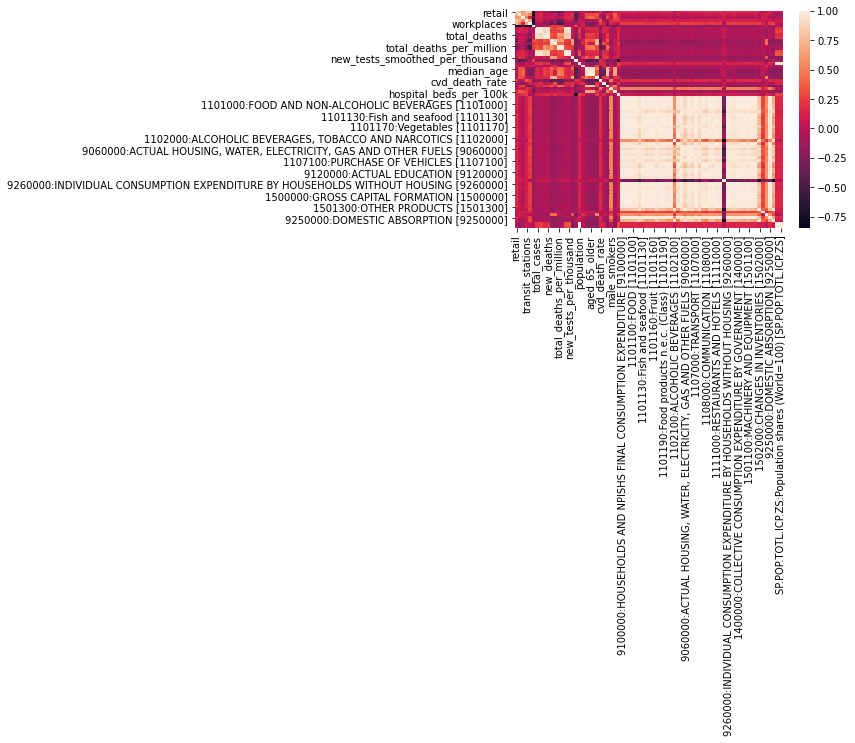

In [0]:
import seaborn as sns

sns.heatmap(corr)

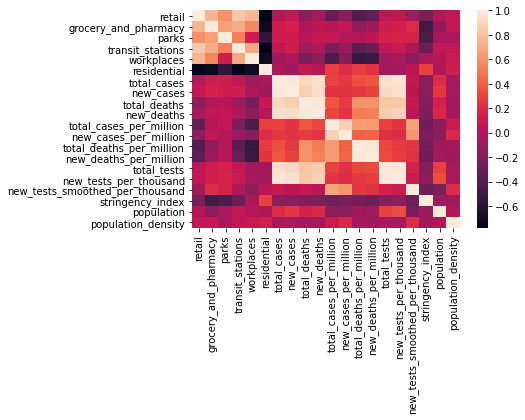

In [0]:
import seaborn as sns
sns.heatmap(corr.iloc[:20,:20])

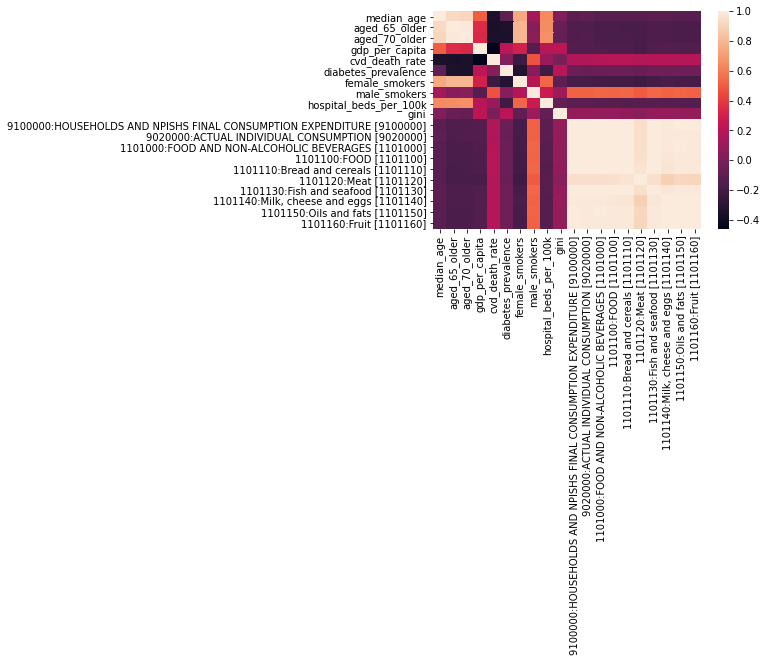

In [0]:
sns.heatmap(corr.iloc[20:40,20:40])

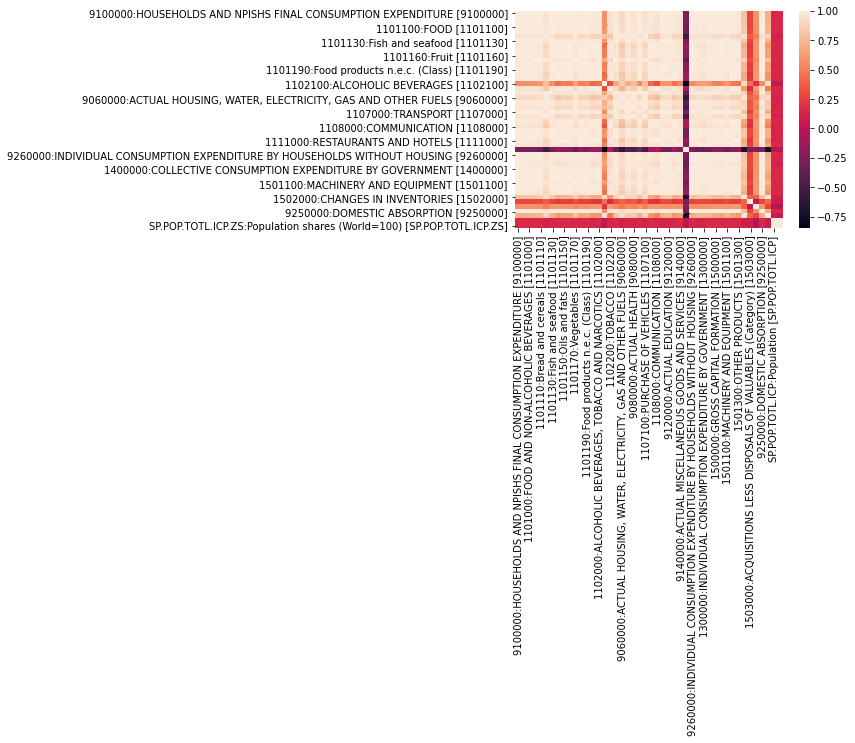

In [0]:
sns.heatmap(corr.iloc[30:,30:])

As we see the last variables has a higher correlation, the same for the firtsones, so i decide to make pca 

In [0]:
dfallvariables.dropna().index

Index(['Mexico', 'Bangladesh', 'New Zealand', 'Bulgaria', 'France', 'Qatar',
       'Indonesia', 'Ireland', 'Colombia', 'Costa Rica', 'Netherlands',
       'Switzerland', 'Saudi Arabia', 'El Salvador', 'Zimbabwe',
       'South Africa', 'Belgium', 'Slovakia', 'Sweden', 'Brazil', 'Luxembourg',
       'Pakistan', 'Argentina', 'Italy', 'Singapore', 'Slovenia',
       'United States', 'Australia', 'India', 'Uganda', 'Germany', 'Panama',
       'Chile', 'Austria', 'Greece', 'Israel', 'Belarus', 'Nepal', 'Turkey',
       'Estonia', 'Malaysia', 'Poland', 'Canada', 'Vietnam', 'Denmark',
       'Japan', 'Philippines', 'Finland', 'Norway', 'Ecuador', 'Croatia',
       'Uruguay', 'Thailand', 'Ghana', 'Portugal', 'Romania', 'Paraguay',
       'United Kingdom', 'Hungary', 'Spain', 'Kazakhstan', 'Bahrain', 'Kenya'],
      dtype='object', name='Countries')

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(dfallvariables.iloc[:,30:])


In [0]:
pca.explained_variance_ratio_

array([0.99999909])

ValueError: ignored

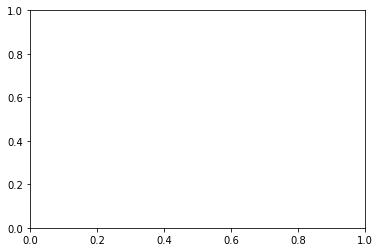

In [0]:
import matplotlib.pyplot as plt

plt.plot(range(0,10), pca.explained_variance_ratio_)

In [0]:
dfallvariables=dfallvariables.iloc[:,:30]

In [0]:
dfallvariables['PCAworldbank']=principalComponents.flatten()

In [0]:
dfallvariables

,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,PCAworldbank
Countries,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mexico,-22.172679,-6.691679,-18.118807,-21.675806,-15.598846,7.622896,6807.601399,395.762238,660.167832,42.587413,55.928496,3.251444,5.423667,0.349867,2.882910e+04,1139.984848,0.008705,33.800362,128932753.0,66.444,29.3,6.857,4.321,17336.469,152.783,13.06,6.9,21.4,1.380,0.809616,5.608301e+07
Bangladesh,-28.111111,-16.634921,-10.015873,-25.492063,-18.333333,10.238095,4963.886076,338.455696,91.215190,4.886076,35.016647,2.387559,0.643353,0.034471,4.059416e+04,2403.371429,0.014557,75.572297,164689383.0,1265.036,27.5,5.098,3.262,3523.984,298.003,8.38,1.0,44.7,0.800,0.710500,9.239551e+07
New Zealand,-35.639810,-14.363198,-38.321361,-31.490255,-17.955619,9.979104,411.347518,8.177305,5.014184,0.148936,89.758388,1.784291,1.094075,0.032470,8.608461e+04,3469.676923,0.719492,44.436103,4822233.0,18.206,37.9,15.322,9.720,36085.843,128.797,8.08,14.8,17.2,2.610,0.631060,-5.874204e+07
Bulgaria,-28.064168,-11.121332,-11.275671,-28.586115,-21.443897,7.927413,940.095890,31.931507,41.657534,1.643836,135.295849,4.595507,5.995274,0.236712,5.267592e+04,1323.636364,0.190515,70.168475,6948445.0,65.180,44.7,20.801,13.272,18563.307,424.688,5.81,30.1,44.4,7.454,0.445162,-5.614235e+07
France,-44.853741,-20.480726,-26.249433,-41.519274,-37.213152,15.725513,43352.118881,1005.909091,7256.811189,196.727273,664.160986,15.410657,111.175434,3.013916,1.415543e+05,12068.892308,0.184923,47.521304,65273512.0,122.578,42.0,19.718,13.079,38605.671,86.060,4.77,30.1,35.6,5.980,0.660881,2.842011e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hungary,-20.332829,-7.965231,8.784710,-18.775510,-20.721088,8.175868,1533.569620,46.088608,166.734177,5.987342,162.872260,4.894857,17.707961,0.635961,4.631525e+04,1877.943662,0.194437,66.798533,9660350.0,108.043,43.4,18.577,11.976,26777.561,278.296,7.55,26.8,34.8,7.020,0.485437,-5.347464e+07
Spain,-49.685714,-27.008744,-38.167460,-44.393991,-36.395238,14.793691,75250.401408,1637.711268,7807.549296,196.394366,1609.469599,35.027662,166.989303,4.200542,1.372301e+06,33260.240000,0.711360,43.163835,46754783.0,93.105,45.5,19.436,13.799,34272.360,99.403,7.17,27.4,31.4,2.970,0.642931,-1.671992e+07
Kazakhstan,-20.587302,-10.380952,-8.190476,-12.079365,-19.269841,7.111111,2204.885714,103.342857,15.271429,0.500000,120.880368,5.665676,0.837206,0.027426,1.685831e+05,8366.838710,0.445581,77.973667,18776707.0,6.681,30.6,6.991,4.625,24055.588,466.792,7.11,7.0,43.1,6.700,0.545784,-4.605701e+07


In [0]:
corr=dfallvariables.corr()

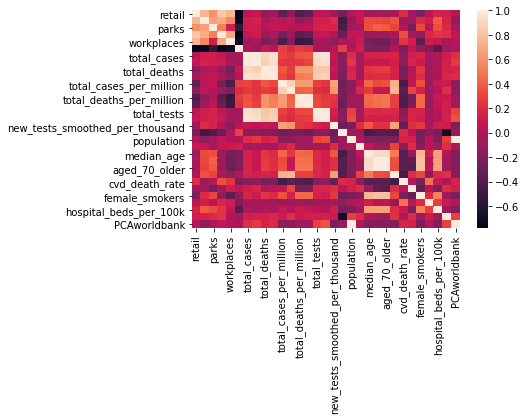

In [0]:
sns.heatmap(corr)

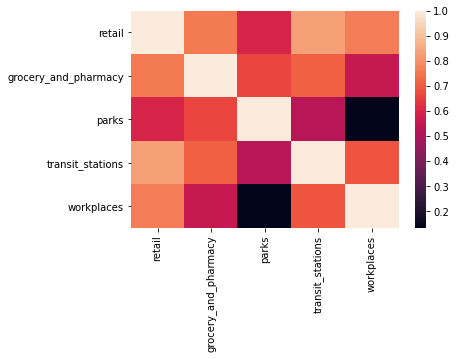

In [0]:
sns.heatmap(corr.iloc[:5,:5])

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(dfallvariables.iloc[:,:5])


In [0]:
dfallvariables=dfallvariables.iloc[:,5:]
dfallvariables

,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,PCAworldbank
Countries,,,,,,,,,,,,,,,,,,,,,,,,,,
Mexico,7.622896,6807.601399,395.762238,660.167832,42.587413,55.928496,3.251444,5.423667,0.349867,2.882910e+04,1139.984848,0.008705,33.800362,128932753.0,66.444,29.3,6.857,4.321,17336.469,152.783,13.06,6.9,21.4,1.380,0.809616,5.608301e+07
Bangladesh,10.238095,4963.886076,338.455696,91.215190,4.886076,35.016647,2.387559,0.643353,0.034471,4.059416e+04,2403.371429,0.014557,75.572297,164689383.0,1265.036,27.5,5.098,3.262,3523.984,298.003,8.38,1.0,44.7,0.800,0.710500,9.239551e+07
New Zealand,9.979104,411.347518,8.177305,5.014184,0.148936,89.758388,1.784291,1.094075,0.032470,8.608461e+04,3469.676923,0.719492,44.436103,4822233.0,18.206,37.9,15.322,9.720,36085.843,128.797,8.08,14.8,17.2,2.610,0.631060,-5.874204e+07
Bulgaria,7.927413,940.095890,31.931507,41.657534,1.643836,135.295849,4.595507,5.995274,0.236712,5.267592e+04,1323.636364,0.190515,70.168475,6948445.0,65.180,44.7,20.801,13.272,18563.307,424.688,5.81,30.1,44.4,7.454,0.445162,-5.614235e+07
France,15.725513,43352.118881,1005.909091,7256.811189,196.727273,664.160986,15.410657,111.175434,3.013916,1.415543e+05,12068.892308,0.184923,47.521304,65273512.0,122.578,42.0,19.718,13.079,38605.671,86.060,4.77,30.1,35.6,5.980,0.660881,2.842011e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hungary,8.175868,1533.569620,46.088608,166.734177,5.987342,162.872260,4.894857,17.707961,0.635961,4.631525e+04,1877.943662,0.194437,66.798533,9660350.0,108.043,43.4,18.577,11.976,26777.561,278.296,7.55,26.8,34.8,7.020,0.485437,-5.347464e+07
Spain,14.793691,75250.401408,1637.711268,7807.549296,196.394366,1609.469599,35.027662,166.989303,4.200542,1.372301e+06,33260.240000,0.711360,43.163835,46754783.0,93.105,45.5,19.436,13.799,34272.360,99.403,7.17,27.4,31.4,2.970,0.642931,-1.671992e+07
Kazakhstan,7.111111,2204.885714,103.342857,15.271429,0.500000,120.880368,5.665676,0.837206,0.027426,1.685831e+05,8366.838710,0.445581,77.973667,18776707.0,6.681,30.6,6.991,4.625,24055.588,466.792,7.11,7.0,43.1,6.700,0.545784,-4.605701e+07


In [0]:
dfallvariables['PCAgrocery']=principalComponents.flatten()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
dfallvariables

,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,PCAworldbank,PCAgrocery
Countries,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mexico,7.622896,6807.601399,395.762238,660.167832,42.587413,55.928496,3.251444,5.423667,0.349867,2.882910e+04,1139.984848,0.008705,33.800362,128932753.0,66.444,29.3,6.857,4.321,17336.469,152.783,13.06,6.9,21.4,1.380,0.809616,5.608301e+07,4.323959
Bangladesh,10.238095,4963.886076,338.455696,91.215190,4.886076,35.016647,2.387559,0.643353,0.034471,4.059416e+04,2403.371429,0.014557,75.572297,164689383.0,1265.036,27.5,5.098,3.262,3523.984,298.003,8.38,1.0,44.7,0.800,0.710500,9.239551e+07,4.368132
New Zealand,9.979104,411.347518,8.177305,5.014184,0.148936,89.758388,1.784291,1.094075,0.032470,8.608461e+04,3469.676923,0.719492,44.436103,4822233.0,18.206,37.9,15.322,9.720,36085.843,128.797,8.08,14.8,17.2,2.610,0.631060,-5.874204e+07,-22.552278
Bulgaria,7.927413,940.095890,31.931507,41.657534,1.643836,135.295849,4.595507,5.995274,0.236712,5.267592e+04,1323.636364,0.190515,70.168475,6948445.0,65.180,44.7,20.801,13.272,18563.307,424.688,5.81,30.1,44.4,7.454,0.445162,-5.614235e+07,3.612948
France,15.725513,43352.118881,1005.909091,7256.811189,196.727273,664.160986,15.410657,111.175434,3.013916,1.415543e+05,12068.892308,0.184923,47.521304,65273512.0,122.578,42.0,19.718,13.079,38605.671,86.060,4.77,30.1,35.6,5.980,0.660881,2.842011e+06,-23.770805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hungary,8.175868,1533.569620,46.088608,166.734177,5.987342,162.872260,4.894857,17.707961,0.635961,4.631525e+04,1877.943662,0.194437,66.798533,9660350.0,108.043,43.4,18.577,11.976,26777.561,278.296,7.55,26.8,34.8,7.020,0.485437,-5.347464e+07,26.680647
Spain,14.793691,75250.401408,1637.711268,7807.549296,196.394366,1609.469599,35.027662,166.989303,4.200542,1.372301e+06,33260.240000,0.711360,43.163835,46754783.0,93.105,45.5,19.436,13.799,34272.360,99.403,7.17,27.4,31.4,2.970,0.642931,-1.671992e+07,-37.919579
Kazakhstan,7.111111,2204.885714,103.342857,15.271429,0.500000,120.880368,5.665676,0.837206,0.027426,1.685831e+05,8366.838710,0.445581,77.973667,18776707.0,6.681,30.6,6.991,4.625,24055.588,466.792,7.11,7.0,43.1,6.700,0.545784,-4.605701e+07,14.008182


# *****Kmeans

Now we are going to do Unsupervised learning to identify correlated countries

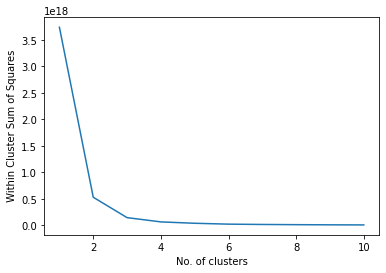

In [0]:
from sklearn.cluster import KMeans
#calculating WCSS which is the sum of squares of the distances of each data point represeting a country
#in all clusters to their respective centroids
wcss=[]
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10)
    y_means = kmeans.fit(dfallvariables)
    wcss.append(y_means.inertia_)
#Plotting WCSS to find the number of clusters
plt.plot(range(1,11), wcss)
plt.xlabel("No. of clusters")
plt.ylabel(" Within Cluster Sum of Squares")
plt.show()

In [0]:
data_k=dfallvariables.copy()
kmeans_covid = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10)
y_kmeans = kmeans.fit_predict(data_k)

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(data_k)


#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1

# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
data_k['cluster'] = list(cluster[0])
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(data_k.groupby('cluster').mean(),1))
kmeans_mean_cluster

,residential,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests_per_thousand,new_tests_smoothed_per_thousand,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_100k,gini,PCAworldbank,PCAgrocery
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,11.2,5719.5,178.6,369.6,11.1,484.5,15.2,21.7,0.7,143116.4,4752.7,0.4,55.2,1.628964e+07,319.3,36.3,13.0,8.4,33151.2,192.6,7.2,15.1,28.0,3.5,0.6,-4.807838e+07,0.1
2,13.0,13171.9,791.3,422.3,24.2,9.5,0.6,0.3,0.0,747592.8,35705.5,0.0,48.3,1.380004e+09,450.4,28.2,6.0,3.4,6426.7,282.3,10.4,1.9,20.6,0.5,0.8,1.199319e+09,-13.7
3,8.0,93288.5,3345.2,5144.9,200.5,298.2,11.1,16.5,0.7,1035552.7,44788.7,0.1,39.6,2.594945e+08,115.5,31.2,8.4,5.2,21138.1,273.7,8.4,8.7,38.8,1.7,0.8,1.770059e+08,10.0
4,11.2,26546.7,743.3,2449.1,71.1,366.1,10.0,36.5,1.0,368147.2,14018.7,0.2,49.2,9.315594e+07,288.7,36.6,13.2,8.9,23845.3,175.4,7.3,12.5,35.1,3.8,0.7,2.535523e+07,-2.6


In [0]:
data_risk= pd.DataFrame()
data_risk["country"]=data_k.index
data_risk["Risk_Level"]=y_kmeans1

In [0]:
for group in range(1,6):
    countries=data_risk.loc[data_risk['Risk_Level']==group]
    listofcoutries= list(countries['country'])
    print("Group", group, ":", listofcoutries)

Group 1 : ['New Zealand', 'Bulgaria', 'Qatar', 'Ireland', 'Colombia', 'Costa Rica', 'Netherlands', 'Switzerland', 'Saudi Arabia', 'El Salvador', 'Zimbabwe', 'Belgium', 'Slovakia', 'Sweden', 'Luxembourg', 'Argentina', 'Singapore', 'Slovenia', 'Australia', 'Uganda', 'Panama', 'Chile', 'Austria', 'Greece', 'Israel', 'Belarus', 'Nepal', 'Estonia', 'Malaysia', 'Poland', 'Canada', 'Denmark', 'Finland', 'Norway', 'Ecuador', 'Croatia', 'Uruguay', 'Ghana', 'Portugal', 'Romania', 'Paraguay', 'Hungary', 'Spain', 'Kazakhstan', 'Bahrain', 'Kenya']
Group 2 : ['India']
Group 3 : ['Indonesia', 'Brazil', 'Pakistan', 'United States']
Group 4 : ['Mexico', 'Bangladesh', 'France', 'South Africa', 'Italy', 'Germany', 'Turkey', 'Vietnam', 'Japan', 'Philippines', 'Thailand', 'United Kingdom']
Group 5 : []


In [0]:
import plotly

In [0]:
data = [dict(type='choropleth',
             colorscale='reds',
             locations =data_risk['country'].astype(str),
             z= data_risk['Risk_Level'].astype(int),
             locationmode='country names')]

fig = dict(data=data, 
           layout_title_text="Country grouped based on Health care quality, no. of COVID-19 cases and tests performed")

plotly.offline.iplot(fig)

In [0]:
data_k.to_csv('datak.csv',index=False)

In [0]:
ls

'coronavirus-disease-covid-19-statistics-and-research (1).csv'
 covid19-global-forecasting-week-5/
 datak.csv
 dfallvariables.csv
 regional-mobility.csv
 total-covid-19-tests-performed-by-country.csv
 worldbank.csv


In [0]:
ndf=[]
ginii=[]
for i in list(set(covid_statistics_research.location.unique()) & set(regionalmobility.country.unique())):
    ndf.append(covid_statistics_research[covid_statistics_research.location==i].describe().iloc[1])
    ginii.append(gini(covid_statistics_research[covid_statistics_research.location==i].iloc[:,3].values.astype('float64')))
nstatisticsdf=pd.DataFrame(ndf)

## charge the principal db
Now We are goin to charge the database of cases to complete the information

In [11]:
%cd /content/interezants/covid19-global-forecasting-week-5

/content/interezants/covid19-global-forecasting-week-5


In [12]:
ls

 Afghanistan
 Angola
'Antigua and Barbuda'
 Argentina
 Australia
'Australia_Australian Capital Territory'
'Australia_New South Wales'
'Australia_Northern Territory'
 Australia_Queensland
'Australia_South Australia'
 Australia_Tasmania
 Australia_Victoria
'Australia_Western Australia'
 Austria
 Bahrain
 Bangladesh
 Barbados
 Belarus
 Belgium
 Belize
 Benin
 best_model.h5
 Bolivia
'Bosnia and Herzegovina'
 Botswana
 Brazil
 Bulgaria
'Burkina Faso'
 Cambodia
 Cameroon
 Canada
 Canada_Alberta
'Canada_British Columbia'
 Canada_Manitoba
'Canada_New Brunswick'
'Canada_Newfoundland and Labrador'
'Canada_Northwest Territories'
'Canada_Nova Scotia'
 Canada_Ontario
'Canada_Prince Edward Island'
 Canada_Quebec
 Canada_Saskatchewan
 Canada_Yukon
 Chile
 Colombia
'Costa Rica'
 Croatia
 databaseuseful.csv
 Denmark
'Denmark_Faroe Islands'
 Denmark_Greenland
'Dibujo sin título.jpg'
'Dominican Republic'
 Ecuador
 Egypt
'El Salvador'
 enriched_covid_19_week_2.csv
 Estonia
 Fiji
 Finland
 France
'France_F

In [0]:
train_df = pd.read_csv("trainw5.csv")

In [0]:
train_df.Country_Region.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burundi',
       'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Grenada', 'Guatemala', 'Guin

In [0]:
train_df

,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
907301,969618,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-30,Fatalities,0.0
907302,969619,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-31,ConfirmedCases,4.0
907303,969620,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-31,Fatalities,0.0
907304,969621,NaN,NaN,Zimbabwe,14240168,0.060711,2020-06-01,ConfirmedCases,25.0


here we are make a new df without some countries

In [0]:
a=list(set(covid_statistics_research.location.unique()) & set(regionalmobility.country.unique()))
a.append('US')


NameError: ignored

In [0]:
train_df=train_df[train_df.Country_Region.isin(a)]

NameError: ignored

In [0]:
traindfFatal=train_df[train_df.Target=='Fatalities'].iloc[:,2:7]
traindfFatal['Fatalities']=train_df[train_df.Target=='Fatalities'].TargetValue
traindfFatal

,Province_State,Country_Region,Population,Weight,Date,Fatalities
1,NaN,Afghanistan,27657145,0.583587,2020-01-23,0.0
3,NaN,Afghanistan,27657145,0.583587,2020-01-24,0.0
5,NaN,Afghanistan,27657145,0.583587,2020-01-25,0.0
7,NaN,Afghanistan,27657145,0.583587,2020-01-26,0.0
9,NaN,Afghanistan,27657145,0.583587,2020-01-27,0.0
...,...,...,...,...,...,...
907297,NaN,Zimbabwe,14240168,0.607106,2020-05-28,0.0
907299,NaN,Zimbabwe,14240168,0.607106,2020-05-29,0.0
907301,NaN,Zimbabwe,14240168,0.607106,2020-05-30,0.0
907303,NaN,Zimbabwe,14240168,0.607106,2020-05-31,0.0


In [0]:
traindfFatal.loc[(traindfFatal['Country_Region'] == 'Colombia') &(traindfFatal.Date == '2020-04-30') ]

,Province_State,Country_Region,Population,Weight,Date,Fatalities
23777,NaN,Colombia,48759958,0.564895,2020-04-30,15.0


In [0]:
import plotly.express as px
df_by_dateFatal = pd.DataFrame(traindfFatal.fillna('NA').groupby(['Country_Region','Date'])['Fatalities'].sum().reset_index())


In [0]:
df_by_dateFatal.loc[(df_by_dateFatal['Country_Region'] == 'Colombia') ]

,Country_Region,Date,Fatalities
3013,Colombia,2020-01-23,0.0
3014,Colombia,2020-01-24,0.0
3015,Colombia,2020-01-25,0.0
3016,Colombia,2020-01-26,0.0
3017,Colombia,2020-01-27,0.0
...,...,...,...
3139,Colombia,2020-05-28,30.0
3140,Colombia,2020-05-29,22.0
3141,Colombia,2020-05-30,36.0
3142,Colombia,2020-05-31,25.0


In [0]:
fig = px.bar(df_by_dateFatal.loc[(df_by_dateFatal['Country_Region'] == 'Brazil') &(df_by_dateFatal.Date >= '2020-03-01')].sort_values('Fatalities',ascending = False), 
             x='Date', y='Fatalities', color='Fatalities', color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Death COVID-19 cases per day in US')
fig.show()

In [0]:
traindfConfirmed=train_df[train_df.Target=='ConfirmedCases'].iloc[:,3:7]
traindfConfirmed['ConfirmedCases']=train_df[train_df.Target=='ConfirmedCases'].TargetValue
traindfConfirmed

,Country_Region,Population,Weight,Date,ConfirmedCases
0,Afghanistan,27657145,0.058359,2020-01-23,0.0
2,Afghanistan,27657145,0.058359,2020-01-24,0.0
4,Afghanistan,27657145,0.058359,2020-01-25,0.0
6,Afghanistan,27657145,0.058359,2020-01-26,0.0
8,Afghanistan,27657145,0.058359,2020-01-27,0.0
...,...,...,...,...,...
907296,Zimbabwe,14240168,0.060711,2020-05-28,17.0
907298,Zimbabwe,14240168,0.060711,2020-05-29,0.0
907300,Zimbabwe,14240168,0.060711,2020-05-30,25.0
907302,Zimbabwe,14240168,0.060711,2020-05-31,4.0


In [0]:
df_by_dateConfirmed = pd.DataFrame(traindfConfirmed.fillna('NA').groupby(['Country_Region','Date'])['ConfirmedCases'].sum().sort_values().reset_index())


In [0]:
fig = px.bar(df_by_date.loc[(df_by_dateConfirmed['Country_Region'] == 'Colombia') &(df_by_dateConfirmed.Date >= '2020-03-01')].sort_values('ConfirmedCases',ascending = False), 
             x='Date', y='ConfirmedCases', color='ConfirmedCases', color_continuous_scale=px.colors.sequential.BuGn)
fig.update_layout(title_text='Confirmed COVID-19 cases per day in Colombia')
fig.show()

In [0]:
traindd=traindfFatal.copy()
traindd['ConfirmedCases']=list(traindfConfirmed['ConfirmedCases'].astype('float64'))

In [0]:
traindd

,Province_State,Country_Region,Population,Weight,Date,Fatalities,ConfirmedCases
1,NaN,Afghanistan,27657145,0.583587,2020-01-23,0.0,0.0
3,NaN,Afghanistan,27657145,0.583587,2020-01-24,0.0,0.0
5,NaN,Afghanistan,27657145,0.583587,2020-01-25,0.0,0.0
7,NaN,Afghanistan,27657145,0.583587,2020-01-26,0.0,0.0
9,NaN,Afghanistan,27657145,0.583587,2020-01-27,0.0,0.0
...,...,...,...,...,...,...,...
907297,NaN,Zimbabwe,14240168,0.607106,2020-05-28,0.0,17.0
907299,NaN,Zimbabwe,14240168,0.607106,2020-05-29,0.0,0.0
907301,NaN,Zimbabwe,14240168,0.607106,2020-05-30,0.0,25.0
907303,NaN,Zimbabwe,14240168,0.607106,2020-05-31,0.0,4.0


In [0]:
traindd.to_csv('databaseuseful.csv',index=False)


# ******Create the Final Db

In [13]:
%cd /content/interezants/covid19-global-forecasting-week-5


/content/interezants/covid19-global-forecasting-week-5


In [0]:
train_df = gpd.read_file("databaseuseful.csv")
train_df["ConfirmedCases"] = train_df["ConfirmedCases"].astype("float")
train_df["Fatalities"] = train_df["Fatalities"].astype("float")
#The country_region got modified in the enriched dataset by @optimo, 
# so we have to apply the same change to this Dataframe to facilitate the merge.
train_df["Country_Region"] = [ row.Country_Region.replace("'","").strip(" ") if row.Province_State=="" else str(row.Country_Region+"_"+row.Province_State).replace("'","").strip(" ") for idx,row in train_df.iterrows()]

In [0]:
train_df

,Province_State,Country_Region,Population,Weight,Date,Fatalities,ConfirmedCases,geometry
0,,Afghanistan,27657145,0.5835873743558676,2020-01-23,0.0,0.0,None
1,,Afghanistan,27657145,0.5835873743558676,2020-01-24,0.0,0.0,None
2,,Afghanistan,27657145,0.5835873743558676,2020-01-25,0.0,0.0,None
3,,Afghanistan,27657145,0.5835873743558676,2020-01-26,0.0,0.0,None
4,,Afghanistan,27657145,0.5835873743558676,2020-01-27,0.0,0.0,None
...,...,...,...,...,...,...,...,...
440417,,Zimbabwe,14240168,0.6071063990125888,2020-05-28,0.0,17.0,None
440418,,Zimbabwe,14240168,0.6071063990125888,2020-05-29,0.0,0.0,None
440419,,Zimbabwe,14240168,0.6071063990125888,2020-05-30,0.0,25.0,None
440420,,Zimbabwe,14240168,0.6071063990125888,2020-05-31,0.0,4.0,None


In [0]:
train=train_df.copy()

In [0]:
ls

best_model.h5       enriched_covid_19_week_2.csv  trainw5.csv
databaseuseful.csv  traindf.csv


In [0]:
#Still using the enriched data from week 2 as there is everything required for the model's training
extra_data_df = gpd.read_file("enriched_covid_19_week_2.csv")
extra_data_df["Country_Region"] = [country_name.replace("'","") for country_name in extra_data_df["Country_Region"]]
extra_data_df["restrictions"] = extra_data_df["restrictions"].astype("int")
extra_data_df["quarantine"] = extra_data_df["quarantine"].astype("int")
extra_data_df["schools"] = extra_data_df["schools"].astype("int")
extra_data_df["total_pop"] = extra_data_df["total_pop"].astype("float")
extra_data_df["density"] = extra_data_df["density"].astype("float")
extra_data_df["hospibed"] = extra_data_df["hospibed"].astype("float")
extra_data_df["lung"] = extra_data_df["lung"].astype("float")
extra_data_df["total_pop"] = extra_data_df["total_pop"]/max(extra_data_df["total_pop"])
extra_data_df["density"] = extra_data_df["density"]/max(extra_data_df["density"])
extra_data_df["hospibed"] = extra_data_df["hospibed"]/max(extra_data_df["hospibed"])
extra_data_df["lung"] = extra_data_df["lung"]/max(extra_data_df["lung"])
extra_data_df["age_100+"] = extra_data_df["age_100+"].astype("float")
extra_data_df["age_100+"] = extra_data_df["age_100+"]/max(extra_data_df["age_100+"])

extra_data_df = extra_data_df[["Country_Region","Date","restrictions","quarantine","schools","hospibed","lung","total_pop","density","age_100+"]]
extra_data_df.head()

,Country_Region,Date,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,Afghanistan,2020-01-22,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
1,Afghanistan,2020-01-23,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
2,Afghanistan,2020-01-24,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
3,Afghanistan,2020-01-25,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411
4,Afghanistan,2020-01-26,0,0,0,0.036232,0.329191,0.027046,0.002278,0.001411


In [0]:
train_df.head()

,Province_State,Country_Region,Population,Weight,Date,Fatalities,ConfirmedCases,geometry
0,,Afghanistan,27657145,0.5835873743558676,2020-01-23,0.0,0.0,None
1,,Afghanistan,27657145,0.5835873743558676,2020-01-24,0.0,0.0,None
2,,Afghanistan,27657145,0.5835873743558676,2020-01-25,0.0,0.0,None
3,,Afghanistan,27657145,0.5835873743558676,2020-01-26,0.0,0.0,None
4,,Afghanistan,27657145,0.5835873743558676,2020-01-27,0.0,0.0,None


In [0]:

extra_data_df.shape

(18816, 10)

In [0]:
train_df.shape

(440422, 8)

In [0]:
train_df = train_df.merge(extra_data_df, how="left", on=['Country_Region','Date']).drop_duplicates()
train_df.head()

,Province_State,Country_Region,Population,Weight,Date,Fatalities,ConfirmedCases,geometry,restrictions,quarantine,schools,hospibed,lung,total_pop,density,age_100+
0,,Afghanistan,27657145,0.5835873743558676,2020-01-23,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
1,,Afghanistan,27657145,0.5835873743558676,2020-01-24,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
2,,Afghanistan,27657145,0.5835873743558676,2020-01-25,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
3,,Afghanistan,27657145,0.5835873743558676,2020-01-26,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411
4,,Afghanistan,27657145,0.5835873743558676,2020-01-27,0.0,0.0,None,0.0,0.0,0.0,0.036232,0.329191,0.027046,0.002278,0.001411


In [0]:
train_df.shape

(440212, 16)

Still need to complete part of the data for dates past the 25th of March as the enriched dataset didn't go that far.

In [0]:
for country_region in train_df.Country_Region.unique():
    query_df = train_df.query("Country_Region=='"+country_region+"' and Date=='2020-03-25'")
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"total_pop"] = query_df.total_pop.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"hospibed"] = query_df.hospibed.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"density"] = query_df.density.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"lung"] = query_df.lung.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"age_100+"] = query_df["age_100+"].values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"restrictions"] = query_df.restrictions.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"quarantine"] = query_df.quarantine.values[0]
    train_df.loc[(train_df["Country_Region"]==country_region) & (train_df["Date"]>"2020-03-25"),"schools"] = query_df.schools.values[0]

As I was using an enriched dataset during the Week 2 competition, I have to add the new countries to my dataframe and fill the missing data with median values.

In [0]:
median_pop = np.median(extra_data_df.total_pop)
median_hospibed = np.median(extra_data_df.hospibed)
median_density = np.median(extra_data_df.density)
median_lung = np.median(extra_data_df.lung)
median_centenarian_pop = np.median(extra_data_df["age_100+"])
#need to replace that with a joint using Pandas
print("The missing countries/region are:")
for country_region in train_df.Country_Region.unique():
    if extra_data_df.query("Country_Region=='"+country_region+"'").empty:
        print(country_region)
        
        train_df.loc[train_df["Country_Region"]==country_region,"total_pop"] = median_pop
        train_df.loc[train_df["Country_Region"]==country_region,"hospibed"] = median_hospibed
        train_df.loc[train_df["Country_Region"]==country_region,"density"] = median_density
        train_df.loc[train_df["Country_Region"]==country_region,"lung"] = median_lung
        train_df.loc[train_df["Country_Region"]==country_region,"age_100+"] = median_centenarian_pop
        train_df.loc[train_df["Country_Region"]==country_region,"restrictions"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"quarantine"] = 0
        train_df.loc[train_df["Country_Region"]==country_region,"schools"] = 0

The missing countries/region are:
Australia
Botswana
Canada_Northwest Territories
Canada_Yukon
Canada
France_Saint Pierre and Miquelon
Netherlands_Bonaire, Sint Eustatius and Saba
Tajikistan
US
United Kingdom_Anguilla
United Kingdom_British Virgin Islands
United Kingdom_Falkland Islands (Malvinas)
United Kingdom_Turks and Caicos Islands
Yemen


I create a new dataframe where I will only store 13-day trends for each location with the resulting numbers on the 14th day. The time periods extracted do not overlap on purpose.

In [0]:
train_df.to_csv('traindf.csv',index=False)